- 第四章 训练模型
- 了解模型时具体如何工作的
- 有助于快速定位到合适的模型、正确的训练算法以及一套适当的超参数
- 后期还能更高效地执行错误调试和错误分析。
- 本章从最简单的线性回归模型开始介绍两种非常不同的训练模型的方法
>1. 通过“闭式”方程——直接计算出最适合训练集的模型参数（也就是使训练集上的成本函数最小化的模型参数）
>2. 使用迭代优化的方法，即梯度下降（GD），逐渐调整模型参数直至训练集上的成本函数调至最低，最终趋同于第一种方法计算出来的模型参数。我们还会研究几个梯度下降的变体，包括批量梯度下降、小批量梯度下降以及随机梯度下降。等我们进入到第二部分神经网络的学习时，会频繁地使用这几个变体。

# 线性回归

## 公式推导

### 线性回归模型预测
$$ \hat{y}=\theta_0+\theta_1X_1+\theta_2X_2+……+\theta_nX_n $$
- $\hat{y}$是预测值
- $n$是特征数量
- $X_i$是第i个特诊值
- $\theta_j$是第j个模型参数

### 线性回归模型预测（向量化）
$$ \hat{y}=h_{\theta}(X)=\theta^T·X $$
- $\theta$是模型的参数向量
- $X$是实例的特征向量，$X_0$永远为1
- $h_\theta$是模型参数$\theta$的假设函数

### 线性回归模型的MSE成本函数
$$ MSE(X, h_\theta)=\frac{1}{m}\sum^m_{i=1}(\theta^T·X^{(i)}-y^{i})^2 $$
>这里要求是让整个成本函数最小的$\theta$值

### 标准方程
$$ \hat{\theta}=(X^T·X)^{-1}·X^T·y $$
- $\hat{\theta}$是使成本函数最小的$\theta$值
- $y$是目标值向量

>公式测试

## 代码实现

In [1]:
import numpy as np

In [11]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)   # 后面加入噪声

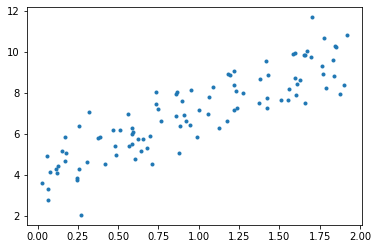

In [12]:
import matplotlib.pyplot as plt
plt.plot(X, y, '.')
plt.axis = ([0, 2, 0, 14])
plt.show()

In [13]:
# 使用标准方差测试公式
X_b = np.c_[np.ones((100, 1)), X]     # 添加X0为1
# linalg.inv()求逆， dot()求内积
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [14]:
theta_best

array([[4.04964624],
       [3.05690949]])

<small>因为有噪声，所以不可能与原来设置的参数完全一样</small>

In [15]:
# 使用theta_best做出预测
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]

In [16]:
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.04964624],
       [10.16346523]])

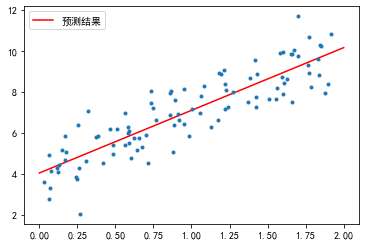

In [17]:
# 预测结果可视化
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(X_new, y_predict, 'r-', label='预测结果')
plt.plot(X, y, '.')
plt.axis = ([0, 2, 0, 14])
plt.legend(loc='upper left')

## 计算复杂度
- 标准方程求逆的矩阵XT·X，是一个n×n矩阵（n是特征数量）。对这种矩阵求逆的计算复杂度通常为O（n2.4）到O（n3）之间（取决于计算实现）。换句话说，如果将特征数量翻倍，那么计算时间将乘以大约22.4＝5.3倍到23＝8倍之间
- 特征数量比较大（例如100000）时，标准方程的计算将极其缓慢
- 训练耗时长，预测时比较快

# 梯度下降

## 理论推导

### 概述
- 梯度下降是一种非常通用的优化算法，能够为大范围的问题找到最优解,梯度下降的中心思想就是迭代地调整参数从而使成本函数最小化
- 假设你迷失在山上的浓雾之中，你能感觉到的只有你脚下路面的坡度。快速到达山脚的一个策略就是沿着最陡的方向下坡。
- 这就是梯度下降的做法：通过测量参数向量θ相关的误差函数的局部梯度，并不断沿着降低梯度的方向调整，直到梯度降为0，到达最小值！
- 具体来说，首先使用一个随机的θ值（这被称为随机初始化），然后逐步改进，每次踏出一步，每一步都尝试降低一点成本函数（如MSE），直到算法收敛出一个最小值

![](img/4-3.png)

### 步长的选取
- 梯度下降中一个重要参数是每一步的步长，这取决于超参数学习率。 
- 如果学习率太低， 算法需要经过大量迭代才能收敛， 这将耗费很长时间
> ![](img/4-4.png)

- 如果学习率太高，那你可能会越过山谷直接到达山的另一边，甚至有可能比之前的起点还要高。这会导致算法发散，值越来越大 最后无法找到好的解决方案
> ![](img/4-5.png)

### 梯度下降陷阱
- 并不是所有的成本函数看起来都像一个漂亮的碗。有的可能看着像洞、像山脉、像高原或者是各种不规则的地形，导致很难收敛到最小值。
- 图4-6显示了梯度下降的两个主要挑战：如果随机初始化，算法从左侧起步，那么会收敛到一个局部最小值，而不是全局最小值。如果算法从右侧起步，那么需要经过很长时间才能越过整片高原，如果你停下得太早，将永远达不到全局最小值
>![](img/4-6.png)

- 线性回归模型的MSE成本函数恰好是个凸函数，所以不存在局部最小值
- 有时候特征值进行缩放会更容易达到全局最小值
>![](img/4-7.png)

### 批量梯度下降

- 要实现梯度下降，需要计算每个模型关于参数$θ_j$的成本函数的梯度。 
- 你需要计算的是如果改变$θ_j$， 成本函数会改变多少。这被称为偏导数
>$$ \frac{\partial}{\partial\theta_j}MSE(\theta)=\frac{2}{m}\sum^m_{i=1}(\theta^T·X^{(i)}-y^{i})x_j^{(i)} $$

- 成本函数梯度向量
>$$ \nabla_{\theta} MSE(\theta)=\frac{2}{m}X^T·(X·\theta-y) $$

- 计算梯度下降的每一步时，都是基于完整的训练集X的。这就是为什么该算法会被称为批量梯度下降：每一步都使用整批训练数据。因此，面对<font color='red'>非常庞大</font>的训练集时，算法会变得极慢（不过我们即将看到快得多的梯度下降算法）。但是，梯度下降算法随<font color='red'>特征数量扩展</font>的表现比较好：如果要训练的线性模型拥有几十万个特征，使用梯度下降比标准方程要快得多。

### 梯度下降步长
$$ \theta^{(nextstep)}=\theta-\eta\nabla_{\theta}MSE(\theta) $$

## 代码实现

In [18]:
eta = 0.1    # 学习率
n_interations = 1000   # 迭代次数
m = 100
theta = np.random.randn(2, 1)
for iteration in range(n_interations):
    grandients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * grandients
print(theta)

[[4.04964624]
 [3.05690949]]


- 结果和上面线性回归的差不多

In [19]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis = ([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

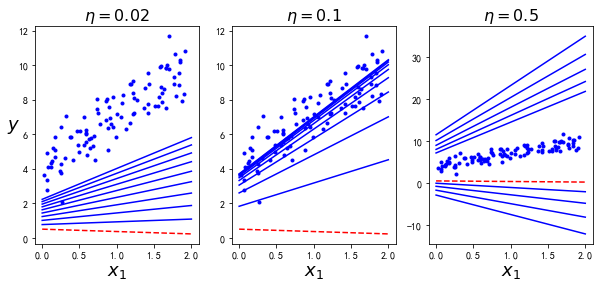

In [20]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

- 左边学习率太低，右边学习率太高
- 可以通过网格搜索找到合适的学习率，需要限制迭代次数
>- 如果设置太低， 算法可能在离最优解还很远时就停了； 
>- 但是如果设置得太高， 模型达到最优解后， 继续迭代参数不再变化， 又会浪费时间。 
>- 一个简单的办法是， 在开始时设置一个非常大的迭代次数， 
>- 但是当梯度向量的值变得很微小时中断算法——也就是当它的范数变得低于（称为容差） 时，
>- 因为这时梯度下降已经（几乎） 到达了最小值。

## 随机梯度下降

### 分析
- 批量梯度下降的主要问题是它要用整个训练集来计算每一步的梯度， 所以训练集很大时， 算法会特别慢。 
- 与之相反的极端是随机梯度下降， 每一步在训练集中随机选择一个实例， 并且仅基于该单个实例
来计算梯度。
- 显然， 这让算法变得快多了， 因为每个迭代都只需要操作少量的数据。 它也可以被用来训练海量的数据集， 因为每次迭代只需要在内存中运行一个实例即可
- 由于算法的随机性质， 它比批量梯度下降要不规则得多。 成本函数将不再是缓缓降低直到抵达最小值， 而是不断上上下下， 但是从整体来看， 还是在慢慢下降。 随着时间推移， 最终会非常接近最小值， 但是即使它到达了最小值， 依旧还会持续反弹， 永远不会停止（见图4-9） 。 所以算法停下来的参数值肯定是<font color='red'>足够好</font>的， 但<mark>不是最优</mark>的。
![](img/4-9.png)
- 随机性的好处在于可以逃离局部最优， 但缺点是永远定位不出最小值。 
- 要解决这个困境，有一个办法是逐步降低学习率。开始的步长比较大（这有助于快速进展和逃离局部最小值），然后越来越小，让算法尽量靠近全局最小值。 （过程叫作模拟退火）

### 代码实现

In [21]:
n_epochs = 50
t0, t1 = 5, 50
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        grandients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eat = learning_schedule(epoch * m + i)
        theta -= eta * grandients

In [22]:
theta

array([[4.24542723],
       [3.03701388]])

### 使用sklearn API实现随机梯度下降

In [23]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, random_state=42, tol=-np.infty)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=50,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [24]:
print('斜率：', sgd_reg.intercept_)    # 截距
print('截距', sgd_reg.coef_)        # 斜率

斜率： [4.06110635]
截距 [3.06541784]


## 小批量梯度下降

- 每一步的梯度计算， 既不是基于整个训练集（如批量梯度下降） 也不是基于单个实例（如随机梯度下降） 
-  而是基于一小部分随机的实例集也就是小批量
- 小批量梯度下降的主要优势在于可以从矩阵运算的硬件优化中获得显著的性能提升， 特别是需要用到图形处理器时
- 这个算法在参数空间层面的前进过程也不像SGD那样不稳定， 特别是批量较大时。 所以小批量梯度下降最终会比SGD更接近最小值一些。 但是另一方面， 它可能更难从局部最小值中逃脱

![](img/4-11.png)

- 线性回归算法比较
<small>m为训练集数量，n为预测集数量</small>

![](img/4-1.png)

# 多项式回归

## 概述
- 如果数据比简单的直线更为复杂， 该怎么办？ 
- 令人意想不到的是， 其实你也可以用线性模型来拟合非线性数据。 
- 一个简单的方法就是将每个特征的幂次方添加为一个新特征， 然后在这个拓展过的特征集上训练线性模型。 
- 这种方法被称为多项式回归。

## 代码实现

In [25]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * (X**2) + X + 2 + np.random.randn(m, 1)

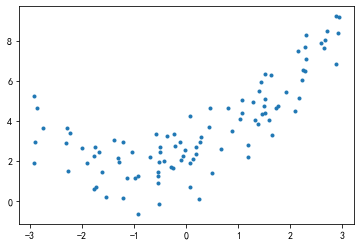

In [26]:
plt.plot(X, y, '.')   # 原始数据

- 显然， 直线永远不可能拟合这个数据。 所以我们使用Scikit-Learn的PolynomialFeatures类来对训练数据进行转换， 将每个特征的平方（二次多项式） 作为新特征加入训练集

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

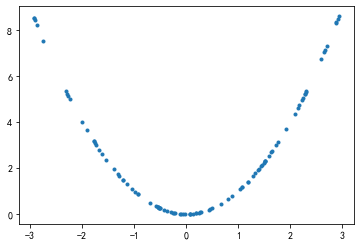

In [28]:
plt.plot(X, X_poly[:,1], '.')

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [30]:
lin_reg.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
print('截距：', lin_reg.intercept_)
print('斜率：', lin_reg.coef_)

截距： [2.23493498]
斜率： [[0.91667792 0.46089666]]


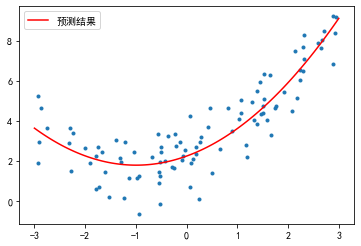

In [32]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, '.')
plt.plot(X_new, y_new, 'r-', label='预测结果')
plt.legend(loc='upper left')

# 学习曲线

## 概述
- 高阶多项式回归对训练数据的拟合， 很可能会比简单线性回归要好。

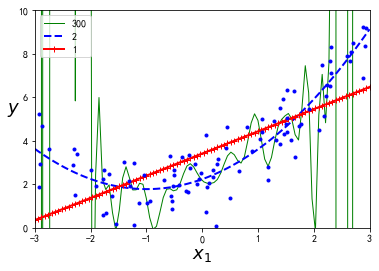

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.xlim(-3,3)
plt.ylim(0,10)
plt.show()

>- 当多项式阶数为300时，出现了过度拟合的现象
>- 线性回归时，无法拟合
>- 多项式为2时拟合效果最好

- 如何确定模型的复杂程度呢？ 怎么才能判断模型是过度拟合还是拟合不足呢？
- 交叉验证来评估模型的泛化性能。 
>- 如果模型在训练集上表现良好， 但是交叉验证的泛化表现非常糟糕， 那么模型就是过度拟合。 
>- 如果在二者上的表现都不佳， 那就是拟合不足。
- 学习曲线
>- 这个曲线绘制的是模型在训练集和验证集上， 关于“训练集大小”的性能函数。 
>- 要生成这个曲线， 只需要在不同大小的训练子集上多次训练模型即可。

## 绘制学习曲线

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='训练集')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='验证集')
    plt.legend(loc='upper right')

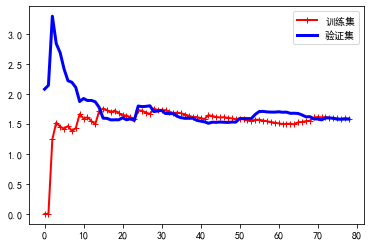

In [77]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 这条学习曲线是典型的模型拟合不足。 两条曲线均到达高地， 非常接近， 而且相当高。

In [79]:
from sklearn.pipeline import Pipeline

(0, 3)

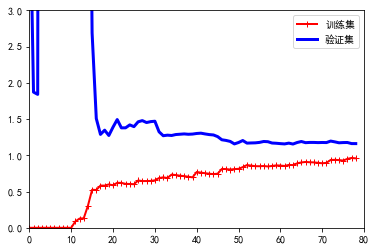

In [87]:
polynomial_regression = Pipeline((
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('sgd_reg', LinearRegression()),
))
plot_learning_curves(polynomial_regression, X, y)
plt.xlim(0,80)
plt.ylim(0,3)

- 这里的误差低于线性回归
- 两条曲线有一定差距，这意味着该模型在训练数据上的表现比验证集上要好很多， 这正是过度拟合的标志

(0, 3)

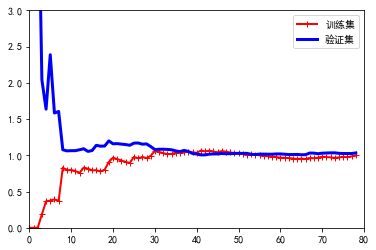

In [91]:
polynomial_regression = Pipeline((
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('sgd_reg', LinearRegression()),
))
plot_learning_curves(polynomial_regression, X, y)
plt.xlim(0,80)
plt.ylim(0,3)

## 偏差/方差权衡

### 在统计学和机器学习领域， 一个重要的理论结果是， 模型的泛化误差可以被表示为三个截然不同的误差之和：

1. 偏差
>这部分泛化误差的原因在于错误的假设，比如假设数据是线性的，而实际上是二次的。高偏差模型最有可能对训练数据拟合不足
2. 方差
> 这部分误差是由于模型对训练数据的微小变化过度敏感导致的。具有高自由度的模型（例如高阶多项式模型）很可能也有高方差，所以很容易对训练数据过度拟合
3. 不可避免误差
> 这部分误差是因为数据本身的噪声所致。 减少这部分误差的唯一方法就是清理数据（例如修复数据源， 如损坏的传感器， 或者是检测并移除异常值）

# 正则线性模型

## 概述
- 减少过度拟合的一个好办法就是对模型正则化（即约束它） ： 它拥有的自由度越低， 就越不容易过度拟合数据。 比如， 将多项式模型正则化的简单方法就是降低多项式的阶数
- 对线性模型来说， 正则化通常通过约束模型的权重来实现。 接下来我们将会使用岭回归（Ridge Regression）、套索回归（LassoRegression）及弹性网络（Elastic Net）这三种不同的实现方法对权重进行约束。

## 岭回归

- 岭回归（也叫作吉洪诺夫正则化） 是线性回归的正则化版： 在成本函数中添加一个等于$ \alpha\sum_{i=1}^n\theta_i^2 $的正则项
- 这使得学习中的算法不仅需要拟合数据， 同时还要让模型权重保持最小
- 注意， 正则项只能在训练的时候添加到成本函数中， 一旦训练完成， 你需要使用未经正则化的性能指标来评估模型性能。
- 超参数α控制的是对模型进行正则化的程度。 如果α=0， 则岭回归就是线性模型。 如果α非常大， 那么所有的权重都将非常接近于零， 结果是一条穿过数据平均值的水平线。

### 岭回归成本函数
$$ J(\theta)=MSE(\theta)+\alpha\frac{1}{2}\sum_{(i=1)}^n\theta_i^2 $$
- 左边是直接使用岭回归，右边是经过10阶多项式后再岭回归

![](img/4-17.png)

### 闭式解的岭回归
<small>其中A是一个n×n的单位矩阵，除了左上单元格为0， 其他与偏置项对应</small>
$$ \hat{\theta}=(X^T·X+\alpha A)^{-1}·X^T·y $$

In [94]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.94257461]])

In [102]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

C:\Users\Davion\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([4.92716094])

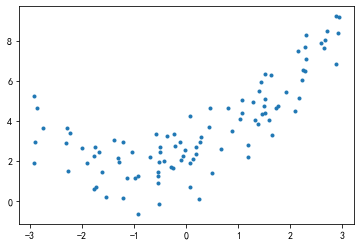

In [103]:
plt.plot(X, y, '.')

## Lasso回归

- 线性回归的另一种正则化， 叫作最小绝对收缩和选择算子回归（Least Absolute Shrinkage and Selection Operator Regression， 简称Lasso回归， 或套索回归）
- 与岭回归一样， 它也是向成本函数增加一个正则项， 但是它增加的是权重向量的l1范数， 而不是l2范数的平方的一半。

### Lasso回归成本函数
$$ J(\theta)=MSE(\theta)+\alpha\sum_{i=1}^n|\theta_i| $$
- Lasso回归的一个重要特点是它倾向于完全消除掉最不重要特征的权重（也就是将它们设置为零）。
- 因为所有高阶多项式的特征权重都等于零。 换句话说， Lasso回归会自动执行特征选择并输出一个稀疏模型（即只有很少的特征有非零权重）
![](img/4-18.png)

![](img/4-19.png)

### Lasso回归次梯度向量
![](img/4-19-1.png)

In [104]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.89715424])

## 弹性网络

- 弹性网络是岭回归与Lasso回归之间的中间地带。 
- 其正则项就是岭回归和Lasso回归的正则项的混合， 混合比例通过r来控制。 
- 当r＝0时， 弹性网络即等同于岭回归， 
- 而当r＝1时， 即相当于Lasso回归

### 弹性网络成本函数
$$ J(\theta)=MSE(\theta)+r\alpha\sum_{i=1}^n|\theta_i|+\frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2 $$

- 那么， 到底如何选用线性回归、 岭回归、 Lasso回归和弹性网络呢？ 
- 通常来说， 有正则化——哪怕是很小， 总是比没有更可取一些。
- 所以大多数情况下， 你应该避免使用纯线性回归。 
- <mark>岭回归是个不错的默认选择</mark>， 
- 但是如果你觉得<mark>实际用到的特征只有少数几个</mark>， 那就应该更倾向于Lasso回归或是弹性网络， 因为它们会将无用特征的权重降为零。
- 一般而言， 弹性网络优于Lasso回归， 因为当特征数量超过训练实例数量， 又或者是几个特征强相关时， Lasso回归的表现可能非常不稳定。

## 早期停止法

- 对于梯度下降这一类迭代学习的算法， 还有一个与众不同的正则化方法， 就是在验证误差达到最小值时停止训练， 该方法叫作早期停止法。 
- 经过一轮一轮的训练， 算法不断地学习， 训练集上的预测误差（RMSE） 自然不断下降， 
- 同样其在验证集上的预测误差也随之下降。
- 但是， 一段时间之后， 验证误差停止下降反而开始回升。
- 这说明模型开始过度拟合训练数据。
- 通过早期停止法， 一旦验证误差达到最小值就立刻停止训练。
- 这是一个非常简单而有效的正则化技巧， 所以Geoffrey Hinton称其为“美丽的免费午餐”。

![](img/4-20.png)

<small>对随机梯度下降和小批量梯度下降来说， 曲线没有这么平滑， 所以很难知道是否已经达到最小值。 <mark>一种解决方法是等验证误差超过最小值一段时间之后再停止</mark>（这时你可以确信模型不会变得更好了） ， 然后将模型参数回滚到验证误差最小时的位置。</small>

### 代码演示

In [108]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

In [109]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

In [111]:
minimun_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimun_val_error:
        minimun_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [114]:
minimun_val_error, best_epoch, best_model

(1.3513110512453865,
 238,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

## 逻辑回归

### 概述
逻辑回归（Logistic回归， 也称为罗吉思回归） 被广泛用于估算一个实例属于某个特定类别的概率。 （比如， 这封电子邮件属于垃圾邮件的概率是多少？ ） 如果预估概率超过50%， 则模型预测该实例属于该类别（称为正类， 标记为“1”） ， 反之， 则预测不是（也就是负类， 标记为“0”） 。 这样它就成了一个二元分类器。

### 概率估算

#### 逻辑回归模型概率估算（向量化形式）
$$ \hat{p}=h_{\theta}(X)=\sigma(\theta^T·x) $$
>逻辑模型（也称为罗吉特），是一个sigmoid函数（即S形），记作σ（·），它的输出为一个0到1之间的数字。

#### 逻辑函数
$$\sigma(t)=\frac{1}{1+exp(-t)}$$

(-0.1, 1.1)

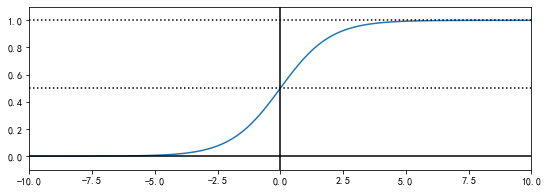

In [123]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot(t, sig, '-')
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.xlim(-10, 10)
plt.ylim(-0.1, 1.1)

#### 逻辑回归模型预测
![](img/4-21-1.png)

### 训练和成本函数

#### 单个训练实例的成本函数
![](img/4-21-2.png)

#### 逻辑回归成本函数（log损失函数）

$$ J(\theta)=-\frac{1}{m}\sum_{i=1}^m[y^ilog(\hat{p}^i)+(1-y^i)log(1-\hat{p}^i)] $$
>- 坏消息是，这个函数没有已知的闭式方程（不存在一个标准方程的等价方程） 来计算出最小化成本函数的θ值。 
>- 好消息是，这是个凸函数，所以通过梯度下降（或是其他任意优化算法）保证能够
找出全局最小值

#### Logistic成本函数的偏导数
$$ \frac{\partial}{\partial\theta_i}J(\theta)=\frac{1}{m}\sum_{i=1}^m(\sigma(\theta^T·x^i)-y^i)x_j^i $$
>计算出每个实例的预测误差， 并将其乘以第j个特征值， 然后再对所有训练实例求平均值。

### 决策边界
- 这里用鸢尾植物数据集来说明逻辑回归

#### iris数据集
- 这是一个非常著名的数据集，
- 共有150朵鸢尾花， 
- 分别来自三个不同品种： Setosa鸢尾花、 Versicolor鸢尾花和Virginica鸢尾花，
- 数据里包含花的萼片以及花瓣的长度和宽度

- 我们试试仅基于花瓣宽度这一个特征， 创建一个分类器来检测
Virginica鸢尾花

In [124]:
from sklearn import datasets
iris = datasets.load_iris()

In [126]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [131]:
iris['feature_names'], iris['target_names']

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

#### 使用逻辑回归，仅基于花瓣宽度这一个特征， 创建一个分类器来检测 Virginica鸢尾花

In [132]:
X = iris['data'][:,3]     # 只看花瓣宽度特征
y = (iris['target'] == 2) # 判断是非为Virginica鸢尾花

In [141]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=42)

In [145]:
log_reg.fit(X.reshape(-1,1), y.reshape(-1,1))

C:\Users\Davion\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [146]:
X_new = np.linspace(0,3,1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

Text(0, 0.5, '概率')

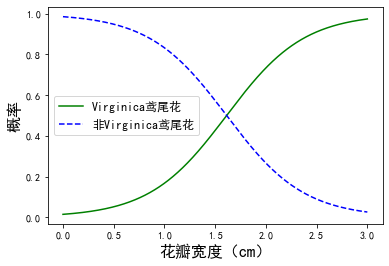

In [158]:
plt.plot(X_new, y_proba[:,1], 'g-', label='Virginica鸢尾花')
plt.plot(X_new, y_proba[:,0], 'b--', label='非Virginica鸢尾花')
plt.legend(loc='center left', fontsize=12)
plt.xlabel('花瓣宽度（cm）', fontsize=16)
plt.ylabel('概率', fontsize=16)

In [159]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

#### 使用逻辑回归，基于花瓣宽度和花瓣长度， 创建一个分类器来检测 Virginica鸢尾花

In [173]:
X = iris['data'][:,(2,3)]
y = (iris['target'] == 2)

In [174]:
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Softmax回归

- 逻辑回归模型经过推广，可以直接支持多个类别，而不需要训练并组合多个二元分类器
- 这就是Softmax回归， 或者叫多元逻辑回归。
- 对于一个给定的实例x，Softmax回归模型首先计算出每个类别k的分数sk（x），然后对这些分数应用softmax函数（也叫归一化指数），估算出每个类别的概率

#### 类别k的Softmax分数
$$ S_k(X)=\theta_k^T·X $$


计算完实例x每个类别的分数后，就可以通过Softmax函数来计算分数：计算出每个分数的指数，然后对它们进行归一化处理（除以所有指数的总和）即得到 ，也就是实例属于类别k的概率

#### Softmax函数
$$ \hat{p}_k=\sigma(S(X))_k=\frac{exp(S_k(X))}{\sum_{j=1}^Kexp(s_j(X))} $$
- K是类别变量
- s（x） 是实例x每个类别的分数的向量
- $ \sigma(S(X))_k $是给定的类别分数下， 实例x属于类别k的概率

#### Softmax回归分类器预测
- 跟逻辑回归分类器一样， Softmax回归分类器将估算概率值最高的类别作为预测类别（也就是分数最高的类别） 
- ·argmax运算符返回的是使函数最大化所对应的变量的值。 在这个等式里， 它返回的是使估算概率（s（x） ） k最大的k的值
$$ \hat{y}=argmax_k\sigma(S(X))_k=argmax_ks_k(X)=argmax_k(\theta_k^T·X) $$

Softmax回归分类器一次只会预测一个类别（也就是说，它是多类别，但是不是多输出），所以它应该仅适用于互斥的类别之上，例如植物的不同种类。 你不能用它来识别一张照片中的多个人

#### 交叉熵成本函数
$$ J(\Theta)=-\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^Ky_k^{(i)}log(\hat{p}_k^{(i)}) $$
- 如果第i个实例的目标类别为k， 则$y_k$等于1， 否则为0。
- 注意， 当只有两个类别（K=2） 时， 该成本函数等价于逻辑回归的成本函数
- 因为当模型对目标类别做出较低概率的估算时， 会受到惩罚。 交叉熵经常被用于衡量一组估算出的类别概率跟目标类别的匹配程度

##### 交叉熵
- 交叉熵源于信息理论。 
- 假设你想要有效传递每天的天气信息，
- 选项（晴、下雨等）有8个，那么你可以用3比特对每个选项进行编码，因为$2^3$=8。
- 但是， 如果你认为几乎每天都是晴天，那么，对“晴天”用1比特（0），其他七个类别用4比特（从1开始）进行编码，显然会更有效率一些。
- 交叉熵衡量的是你每次发送天气选项的平均比特数。
- 如果你对天气的假设是完美的， 交叉熵将会等于天气本身的熵（也就是其本身固有的不可预测性）。
- 但是如果你的假设是错误的（比如经常下雨），交叉熵将会变大，增加的这一部分我们称之为KL散度（Kullback-Leibler divergence， 也叫作相对熵） 。

- 两个概率分布p和q之间的交叉熵定义为H（p， q） =-Σxp（x） log q（x） 至少在离散分布时可以这样定义）

#### 对于类别k的交叉熵梯度向量
$$ \nabla_{\theta_{k}}J{\Theta}=\frac{1}{m}\sum_{i=1}^m(\hat{p}_k^{(i)}-y_k^{(i)})X^{(i)} $$

In [188]:
X = iris['data'][:,(2,3)]
y = iris['target']

In [194]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [195]:
softmax_reg.predict([[5, 2]])

array([2])

In [196]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

(0, 3.5)

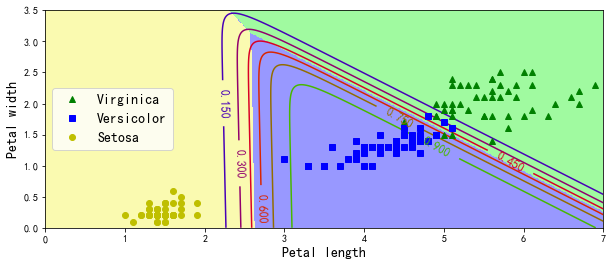

In [198]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.xlim(0, 7)
plt.ylim(0, 3.5)